**Imports**

In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from itertools import combinations

### Data Preparation

Importing the cleaned data and creating the train - validation - test data


In [509]:
continous_var_bin_number = 2

In [510]:
cleaned_data = pd.read_csv("/Users/marcellszegedi/Documents/Data_Mining/cleaned_data_msz_final.csv", sep=";", decimal=",")
cleaned_data.drop(["experience_st", "pleasant_thing_1", "pleasant_thing_2"], axis="columns", inplace=True)
print(cleaned_data.isna().sum())
print(cleaned_data.columns)

programme              0
experience_ml          0
experience_ir          0
experience_db          0
gender                 0
chatgpt_usage          0
birthday               0
count_students         0
stress_level           0
hours_spend_w_sport    0
bedtime                0
dtype: int64
Index(['programme', 'experience_ml', 'experience_ir', 'experience_db',
       'gender', 'chatgpt_usage', 'birthday', 'count_students', 'stress_level',
       'hours_spend_w_sport', 'bedtime'],
      dtype='object')


In [511]:
datatypes = {
    "programme": str,
    "experience_ml": str,
    "experience_ir": str,
    "experience_db": str,
    "gender": str,
    "chatgpt_usage": str,
    "birthday": np.int16,
    "count_students": np.int16,
    "stress_level": np.float64,
    "hours_spend_w_sport": np.float64,
    "bedtime": np.float64
}
cleaned_data = cleaned_data.astype(datatypes)
print(cleaned_data.dtypes)

programme               object
experience_ml           object
experience_ir           object
experience_db           object
gender                  object
chatgpt_usage           object
birthday                 int16
count_students           int16
stress_level           float64
hours_spend_w_sport    float64
bedtime                float64
dtype: object


In [512]:
test_size = 0.2
valid_size = 0.2

In [513]:
input_attr_cols = ['experience_ml', 'experience_ir', 'experience_db', 'gender', 'chatgpt_usage', 'birthday', 'count_students', 'stress_level',
                           'hours_spend_w_sport', 'bedtime']
target_var_col = "programme"

In [514]:
#strat_cols = ['experience_ml', 'experience_ir', 'experience_db', 'gender', 'chatgpt_usage', 'birthday', 'count_students', 'stress_level', 'hours_spend_w_sport', 'bedtime']
strat_cols = ['birthday_bin', 'hours_spend_w_sport_bin', 'bedtime_bin']

cleaned_data["birthday_bin"] = pd.qcut(cleaned_data["birthday"], q=continous_var_bin_number, duplicates='drop')
cleaned_data["count_students_bin"] = pd.qcut(cleaned_data["count_students"], q=continous_var_bin_number, duplicates="drop")
cleaned_data["stress_level_bin"] = pd.qcut(cleaned_data["stress_level"], q=continous_var_bin_number, duplicates="drop")
cleaned_data["hours_spend_w_sport_bin"] = pd.qcut(cleaned_data["hours_spend_w_sport"], q=continous_var_bin_number, duplicates="drop")
cleaned_data["bedtime_bin"] = pd.qcut(cleaned_data["bedtime"], q=continous_var_bin_number, duplicates="drop")

cleaned_data["strat_col"] = cleaned_data[strat_cols].astype(str).agg("_".join, axis=1)

In [515]:

train_val_data, test_data = train_test_split(cleaned_data, test_size=test_size, stratify=cleaned_data["strat_col"], random_state=100)
train_data, valid_data = train_test_split(train_val_data, test_size=valid_size, stratify=train_val_data["strat_col"], random_state=101)

cleaned_data.drop(["birthday_bin", "count_students_bin", "stress_level_bin", "hours_spend_w_sport_bin", "bedtime_bin", "strat_col"], axis="columns", inplace=True)
print(cleaned_data.columns)

Index(['programme', 'experience_ml', 'experience_ir', 'experience_db',
       'gender', 'chatgpt_usage', 'birthday', 'count_students', 'stress_level',
       'hours_spend_w_sport', 'bedtime'],
      dtype='object')


In [516]:
test_target = test_data[target_var_col]
test_attr = test_data[input_attr_cols]

valid_target = valid_data[target_var_col]
valid_attr = valid_data[input_attr_cols]

train_target = train_data[target_var_col]
train_attr = train_data[input_attr_cols]

### Model Fitting

In [517]:
categorical_features = ['experience_ml', 'experience_ir', 'experience_db', 'gender', 'chatgpt_usage']
numeric_features = ['birthday', 'count_students', 'stress_level', 'hours_spend_w_sport', 'bedtime']

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=100))
])

encoder = LabelEncoder()

To reduce the risk coming from the data separation (into train and validation), lets rerun the fitting multiple times.

In [518]:
def evaluate_combination(df, features, target, n_repeats=25, test_size=0.2):
    X = df[features]
    y = df[target]

    # Separate categorical and numerical columns
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_cols = X.select_dtypes(include=['float', 'int']).columns.tolist()

    # Preprocessing
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    # Classifier pipeline
    tree_clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ])

    sss = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size)
    acc_scores = []
    prec_scores = []
    f_1_scores = []

    for train_idx, test_idx in sss.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        tree_clf.fit(X_train, y_train)
        y_pred = tree_clf.predict(X_test)

        acc_scores.append(accuracy_score(y_test, y_pred))
        prec_scores.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        f_1_scores.append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

    return np.mean(np.array(acc_scores)), np.mean(np.array(prec_scores)), np.mean(np.array(f_1_scores))

To find how many attributes yield the best result, run the fitting for every combination for all the numbers above a threshold.

In [519]:
def search_best_combinations(df, target, min_comb_size=2, n_repeats=5):
    features = df.drop(columns=[target]).columns.tolist()
    accuracy_stat = []
    precision_stat = []
    f1_stat = []

    attr_combos_acc = []
    attr_combos_prec = []
    attr_combos_f1 = []

    for r in range(min_comb_size, len(features) + 1):
        max_acc = 0
        max_acc_attr = []
        max_prec = 0
        max_prec_attr = []
        max_f1 = 0
        max_f1_attr = []
        for attr_combo in combinations(features, r):
            attributes = list(attr_combo)
            acc, prec, f1 = evaluate_combination(df, attributes, target, n_repeats=n_repeats)

            if acc > max_acc:
                max_acc = acc
                max_acc_attr = attributes
            if prec > max_prec:
                max_prec = prec
                max_prec_attr = attributes
            if f1 > max_f1:
                max_f1 = f1
                max_f1_attr = attributes

        accuracy_stat.append(max_acc)
        precision_stat.append(max_prec)
        f1_stat.append(max_f1)

        attr_combos_acc.append(max_acc_attr)
        attr_combos_prec.append(max_prec_attr)
        attr_combos_f1.append(max_f1_attr)
        print(f"{r} DONE")

    return np.arange(min_comb_size, len(features) + 1), np.array(accuracy_stat), np.array(precision_stat), np.array(f1_stat), attr_combos_acc, attr_combos_prec, attr_combos_f1


In [520]:
n_attr, accuracy, precision, f1, acc_attr, prec_attr, f1_attr  = search_best_combinations(
    cleaned_data,
    "programme",
    min_comb_size=3,
    n_repeats=50
)

3 DONE
4 DONE
5 DONE
6 DONE
7 DONE
8 DONE
9 DONE
10 DONE


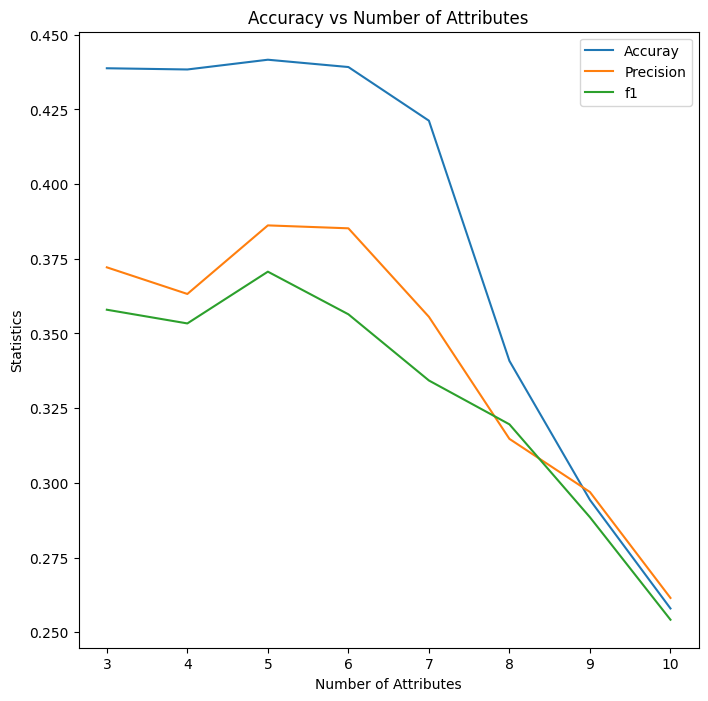

In [521]:
plt.figure(figsize=(8, 8))
plt.plot(n_attr, accuracy, label="Accuray")
plt.plot(n_attr, precision, label="Precision")
plt.plot(n_attr, f1, label="f1")

plt.title("Accuracy vs Number of Attributes")
plt.xlabel("Number of Attributes")
plt.ylabel("Statistics")

plt.legend()
plt.show()

In [522]:
print(acc_attr[2])

['experience_ml', 'experience_db', 'gender', 'chatgpt_usage', 'count_students']


In [523]:
categorical_features = ['experience_ml', 'experience_db', 'gender', 'chatgpt_usage']
numeric_features = ['count_students']
target_var_col = 'programme'
test_size = 0.2

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=100))
])

encoder = LabelEncoder()
train_val_data, test_data = train_test_split(cleaned_data, test_size=test_size, random_state=100)

y_train = encoder.fit_transform(train_val_data[target_var_col])
y_test = encoder.transform(test_data[target_var_col])

X_train = train_val_data[categorical_features + numeric_features]
pipeline.fit(X_train, y_train)

X_test = test_data[categorical_features + numeric_features]
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.4f}")

Accuracy: 0.2857
Precision: 0.2217
F1: 0.2350
